In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib


In [2]:
#Load and Inspect the Data
df = pd.read_csv("slope_stability_dataset.csv")

df.head()


,Unit Weight (kN/m?),Cohesion (kPa),Internal Friction Angle (?),Slope Angle (?),Slope Height (m),Pore Water Pressure Ratio,Reinforcement Type,Reinforcement Numeric,Factor of Safety (FS)
0,18.745401,21.813837,38.249958,41.907228,18.451042,0.847237,Drainage,3,2.613692
1,24.507143,19.981044,24.612800,32.964623,9.266800,0.494517,Geosynthetics,2,2.241626
2,22.319939,12.926926,28.665992,58.224926,10.686165,0.195466,Retaining Wall,0,1.568244
3,20.986585,32.327000,36.582016,20.948923,13.130201,0.736642,Drainage,3,3.000000
4,16.560186,26.448087,32.052234,39.392821,14.164400,0.418678,Soil Nailing,1,3.000000


In [3]:
import pandas as pd


df = pd.read_csv("slope_stability_dataset.csv")


df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace(r'[^\w\s]', '', regex=True)
)


rename_map = {
    'factor_of_safety_fs': 'fs',
    'reinforcement_numeric': 'reinforcement',
}
df.rename(columns=rename_map, inplace=True)

assert 'fs' in df.columns, "Missing column: fs"
assert 'reinforcement' in df.columns, "Missing column: reinforcement"


if 'rockfall_risk' not in df.columns:
    df['rockfall_risk'] = ((df['fs'] < 1.4) | (df['reinforcement'] < 0.4)).astype(int)


df.dropna(subset=['fs', 'reinforcement'], inplace=True)


df.head()


,unit_weight_knm,cohesion_kpa,internal_friction_angle_,slope_angle_,slope_height_m,pore_water_pressure_ratio,reinforcement_type,reinforcement,fs,rockfall_risk
0,18.745401,21.813837,38.249958,41.907228,18.451042,0.847237,Drainage,3,2.613692,0
1,24.507143,19.981044,24.612800,32.964623,9.266800,0.494517,Geosynthetics,2,2.241626,0
2,22.319939,12.926926,28.665992,58.224926,10.686165,0.195466,Retaining Wall,0,1.568244,1
3,20.986585,32.327000,36.582016,20.948923,13.130201,0.736642,Drainage,3,3.000000,0
4,16.560186,26.448087,32.052234,39.392821,14.164400,0.418678,Soil Nailing,1,3.000000,0


In [4]:
#Data Cleaning / Prep
df.isnull().sum()
df.dropna(subset=['fs', 'reinforcement'], inplace=True)

df['rockfall_risk'].value_counts()


rockfall_risk
0    6767
1    3233
Name: count, dtype: int64

In [5]:
#Feature Selection

features = ['fs', 'reinforcement']

X = df[features]
y = df['rockfall_risk']


In [6]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
#Train a Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


joblib.dump(model, "rockfall_model_fs_reinforcement.pkl")
print("Model saved as rockfall_model_fs_reinforcement.pkl")


Model saved as rockfall_model_fs_reinforcement.pkl


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1336
           1       1.00      1.00      1.00       664

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



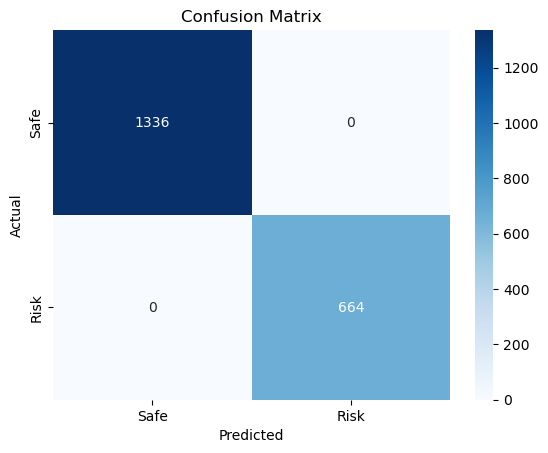

In [8]:
#Evaluate the Model
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Safe", "Risk"], yticklabels=["Safe", "Risk"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [9]:
#Try Another Model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))


Logistic Regression Accuracy: 0.9325


In [10]:
#Load & Use Trained Model

model = joblib.load("rockfall_model_fs_reinforcement.pkl")

sample = pd.DataFrame([[1.2, 0.3]], columns=['fs', 'reinforcement'])
model.predict(sample)


array([1])

In [11]:
#Hyperparameter Tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
}


rf = RandomForestClassifier(random_state=42)


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

joblib.dump(best_rf, "rockfall_model_tuned.pkl")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


['rockfall_model_tuned.pkl']

In [12]:
import joblib


joblib.dump(best_rf, 'rockfall_model_fs_reinforcement.pkl')  # same name used in your Streamlit code
print(" Model saved as rockfall_model_fs_reinforcement.pkl")


 Model saved as rockfall_model_fs_reinforcement.pkl


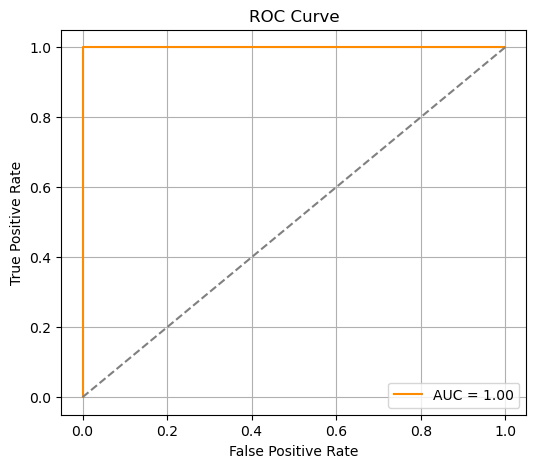

In [13]:
#ROC Curve & AUC
from sklearn.metrics import roc_curve, roc_auc_score


y_probs = best_rf.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)


plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


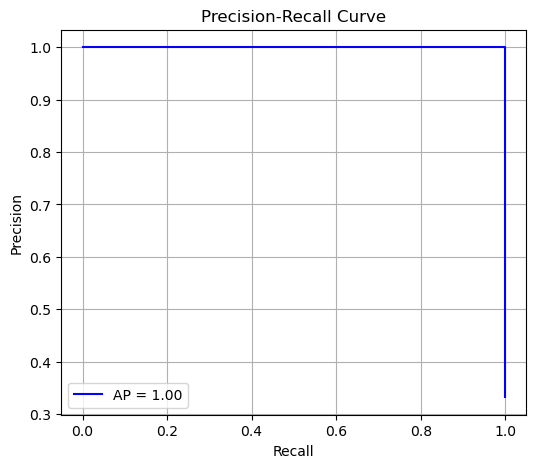

In [14]:
#Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_prec = average_precision_score(y_test, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='blue', label=f'AP = {avg_prec:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


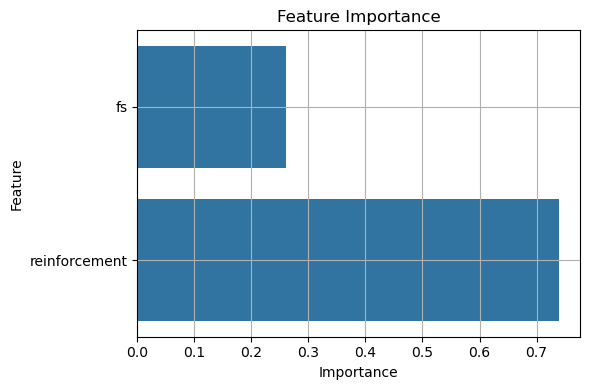

In [15]:
#Feature Importance Plot
importances = best_rf.feature_importances_
feature_names = X.columns


plt.figure(figsize=(6, 4))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
#Compare with Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, logreg_pred))
print("\nClassification Report:\n", classification_report(y_test, logreg_pred))


Logistic Regression Accuracy: 0.9325

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1336
           1       0.88      0.92      0.90       664

    accuracy                           0.93      2000
   macro avg       0.92      0.93      0.92      2000
weighted avg       0.93      0.93      0.93      2000



In [17]:
import os
os.getcwd()


'C:\\Users\\Lenovo\\Desktop\\AI Based Rockfall Prediction And Alert System in Open Pit Mines'

In [18]:
import joblib
import os

project_dir = r"C:\Users\Lenovo\Desktop\AI Based Rockfall Prediction And Alert System in Open Pit Mines"


model_path = os.path.join(project_dir, "rockfall_model_fs_reinforcement.pkl")
joblib.dump(best_rf, model_path)

print(f" Model saved at: {model_path}")


 Model saved at: C:\Users\Lenovo\Desktop\AI Based Rockfall Prediction And Alert System in Open Pit Mines\rockfall_model_fs_reinforcement.pkl


In [19]:
import joblib

joblib.dump(best_rf, "rockfall_model_fs_reinforcement.pkl")


['rockfall_model_fs_reinforcement.pkl']

In [20]:
import joblib

joblib.dump(model, "rockfall_model_fs_reinforcement.pkl")


['rockfall_model_fs_reinforcement.pkl']

In [21]:
import joblib

model = joblib.load("rockfall_model_fs_reinforcement.pkl")


In [22]:
import joblib

model = joblib.load("rockfall_model_fs_reinforcement.pkl")
